# Exploring the Rosetta Stone of Human Capital

## An assignment for the course `Machine Learning in Practise`.
---

> Adam Panagiotidis, 8170096 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> adampanag06@gmail.com

## Importing libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import seaborn as sns
import scipy.stats.stats as stats

%matplotlib inline

## Obtaining Data

The results of the study are available at <https://www.cgdev.org/sites/default/files/patel-sandefur-human-capital-final-results.xlsx>. You will also download the complete replication materials from [here](https://drive.google.com/drive/folders/1p4PCDOBPXkhkP9nIgLSDXatLvPqNwdTh).

In addition, you will need the following files:

* [US 2000 Census Data](usa_00001.csv.gz). Permission to use the data has been graciously granted by IPUMS USA, and the original publication is: Steven Ruggles, Sarah Flood, Ronald Goeken, Josiah Grover, Erin Meyer, Jose Pacas and Matthew Sobek. IPUMS USA: Version 10.0 [dataset]. Minneapolis, MN: IPUMS, 2020. https://doi.org/10.18128/D010.V10.0.

* [BACI (Base Pour L’ Analyse du Commerce International) Country Trade Data](BACI_HS17_Y2018_V202001.csv.gz). The original publication is: BACI: International Trade Database at the Product-Level. The 1994-2007 Version CEPII Working Paper, N°2010-23, Octobre 2010, Guillaume Gaulier, Soledad Zignago.

* [Country Codes file](country_codes_V202001.csv), also provided by BACI.

## File Paths

So, after you have downloaded all the necessary files, you must put them in the right place.

You should put all the files in a folder named `data`. For example, if the notebook file is in the relative path `Desktop/rosetta/`, the data files should be in the relative path `Desktop/rosetta/data/`.

In [2]:
study_results_excel = "data/patel-sandefur-human-capital-final-results.xlsx"
income_countries_file = "data/WDI_data.csv"
avg_school_years_file = 'data/BL2013_MF1599_v2.2.dta'
wb_estimates_file = 'data/HLO Panel Data (mean, thresh) - Jan 2018.dta'
usa_file = 'data/usa_00001.csv'
cw_ind_file = 'data/cw_ind2000_ind1990ddx.dta'
baci_file = 'data/BACI_HS17_Y2018_V202001.csv'
cw_hs6_sic87dd_file = 'data/cw_hs6_sic87dd.dta'
cw_sic87_ind1990ddx_file = 'data/cw_sic87_ind1990ddx.dta'
country_codes_file = 'data/country_codes_V202001.csv'

## Q1: Income and Test Results

We will investigate the relationship between income and PIRLS score, and income and TIMSS score of every country.

* income: the logged gdp per capita.
* TIMSS: median math score of 4th grade students.
* PIRLS: median reading score of 4th grade students.

Let's read the file that contains the scores and give the right data types to its columns.

In [3]:
headers = pd.read_excel(study_results_excel,
                        sheet_name="Country Scores",
                        nrows=0).columns.tolist()
headers

['Country',
 'Country Code',
 'Percent Above Math Benchmark (400 on TIMSS Scale)',
 'Percent Above Reading Benchmark (400 on PIRLS Scale)',
 'Median Math Score (TIMSS Scale, 4th Grade)',
 'Median Reading Score (PIRLS Scale, 4th Grade)']

In [4]:
data_types = { header: np.float for header in headers }
data_types['Country'] = np.str
data_types['Country Code'] = np.str
data_types

{'Country': str,
 'Country Code': str,
 'Percent Above Math Benchmark (400 on TIMSS Scale)': float,
 'Percent Above Reading Benchmark (400 on PIRLS Scale)': float,
 'Median Math Score (TIMSS Scale, 4th Grade)': float,
 'Median Reading Score (PIRLS Scale, 4th Grade)': float}

In [5]:
country_scores = pd.read_excel(study_results_excel,
                               sheet_name="Country Scores",
                               dtype=data_types)

print(country_scores.shape)
country_scores.head(5)

(78, 6)


,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,U.A.E.,ARE,64.000000,63.982311,437.000000,440.000000
1,Argentina,ARG,51.000000,66.000000,406.652557,431.443542
2,Armenia,ARM,71.505402,NaN,454.000000,NaN
3,Australia,AUS,90.000000,92.932800,520.000000,534.000000
4,Austria,AUT,95.302193,97.104111,511.000000,533.000000


Now, we will read the file that contains income data per country as given by the World Bank.

In [6]:
income_countries = pd.read_csv(income_countries_file)

print(income_countries.shape)
income_countries.head(5)

(797, 5)


,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,1809.01648820483
1,Afghanistan,AFG,"School enrollment, primary (% net)",SE.PRM.NENR,..
2,Afghanistan,AFG,"School enrollment, primary (% gross)",SE.PRM.ENRR,107.225357055664
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,10971.2925173789
4,Albania,ALB,"School enrollment, primary (% net)",SE.PRM.NENR,95.1996002197266


We want to keep only the data about the GDP per capita for each country, which has a Series Code `NY.GDP.PCAP.PP.KD`.

In [7]:
gdp_per_country = income_countries[['Country Name', 'Country Code', '2015 [YR2015]']][income_countries['Series Code'] == 'NY.GDP.PCAP.PP.KD'].reset_index(drop=True)

print(gdp_per_country.shape)
gdp_per_country.head(5)

(264, 3)


,Country Name,Country Code,2015 [YR2015]
0,Afghanistan,AFG,1809.01648820483
1,Albania,ALB,10971.2925173789
2,Algeria,DZA,13724.723852895
3,American Samoa,ASM,..
4,Andorra,AND,..


We see that there are some GDPs with `..` as a value. Let's get rid of them.

In [8]:
gdp_per_country = gdp_per_country[gdp_per_country['2015 [YR2015]'] != '..']

gdp_per_country.head(5)

,Country Name,Country Code,2015 [YR2015]
0,Afghanistan,AFG,1809.01648820483
1,Albania,ALB,10971.2925173789
2,Algeria,DZA,13724.723852895
5,Angola,AGO,6231.06799206401
6,Antigua and Barbuda,ATG,20154.9474879241


Make GDP `float`.

In [9]:
gdp_per_country = gdp_per_country.astype({'2015 [YR2015]': 'float'})

Now, we will merge the `country scores` with the `GDP` of each country and we will keep only the necessary columns.

In [10]:
gdp_grades_per_country = pd.merge(gdp_per_country,
                                  country_scores.iloc[:, [1, 4, 5]],
                                  on='Country Code',
                                  how='inner').sort_values(by='2015 [YR2015]', ascending=False)\
                                              .reset_index(drop=True)

print(gdp_grades_per_country.shape)
gdp_grades_per_country.head(5)

(78, 5)


,Country Name,Country Code,2015 [YR2015],"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,Qatar,QAT,119749.428536,416.0,429.0
1,Singapore,SGP,80892.064838,612.0,573.0
2,Kuwait,KWT,68476.325041,346.0,394.0
3,United Arab Emirates,ARE,65975.375547,437.0,440.0
4,Norway,NOR,64008.286830,497.0,510.0


Rename columns.

In [11]:
gdp_grades_per_country.rename(columns={'2015 [YR2015]':'GDP',
                          'Median Math Score (TIMSS Scale, 4th Grade)':'TIMSS',
                          'Median Reading Score (PIRLS Scale, 4th Grade)':'PIRLS'}, 
                 inplace=True)

print(gdp_grades_per_country.columns)

Index(['Country Name', 'Country Code', 'GDP', 'TIMSS', 'PIRLS'], dtype='object')


Calculate the `logged GDP`.

In [12]:
gdp_grades_per_country['GDP'] = np.log(gdp_grades_per_country['GDP'])

gdp_grades_per_country.head(5)

,Country Name,Country Code,GDP,TIMSS,PIRLS
0,Qatar,QAT,11.693157,416.0,429.0
1,Singapore,SGP,11.300871,612.0,573.0
2,Kuwait,KWT,11.134243,346.0,394.0
3,United Arab Emirates,ARE,11.097037,437.0,440.0
4,Norway,NOR,11.066768,497.0,510.0


Now, we will investigate the relationship between `logged income` and `TIMSS`. So, we will put the in a dataframe.

In [13]:
gdp_timss = gdp_grades_per_country.iloc[:, :4]

gdp_timss.head(5)

,Country Name,Country Code,GDP,TIMSS
0,Qatar,QAT,11.693157,416.0
1,Singapore,SGP,11.300871,612.0
2,Kuwait,KWT,11.134243,346.0
3,United Arab Emirates,ARE,11.097037,437.0
4,Norway,NOR,11.066768,497.0


In [14]:
gdp_timss.isna().sum()

Country Name    0
Country Code    0
GDP             0
TIMSS           7
dtype: int64

We see that there are some `NaN` values that we need to drop.

In [15]:
gdp_timss.dropna(inplace=True)
gdp_timss.reset_index(drop=True, inplace=True)
gdp_timss.head()

,Country Name,Country Code,GDP,TIMSS
0,Qatar,QAT,11.693157,416.0
1,Singapore,SGP,11.300871,612.0
2,Kuwait,KWT,11.134243,346.0
3,United Arab Emirates,ARE,11.097037,437.0
4,Norway,NOR,11.066768,497.0


Let's do a regression using the `ols` method of `statsmodels.formula.api`.

In [16]:
mod = smf.ols("TIMSS ~ GDP", data=gdp_timss)
gdp_timss_res = mod.fit()
gdp_timss_res.params

Intercept    46.117041
GDP          41.745974
dtype: float64

* So, the relationship between `TIMSS` ($y$) and `logged income` ($x$) is:

$$ y = 46.117041 + 41.745974 x $$

* Below, is the summary table of the model.

In [17]:
gdp_timss_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TIMSS   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     37.42
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           5.07e-08
Time:                        16:07:58   Log-Likelihood:                -396.25
No. Observations:                  71   AIC:                             796.5
Df Residuals:                      69   BIC:                             801.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.1170     66.734      0.691      0.492     -87.013     179.247
GDP           41.7460      6.824      6.117      0.000      28.132      55.360
==============================================================================
Omnibus:                        1.225   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                1.078
Skew:                          -0.298   Prob(JB):                        0.583
Kurtosis:                       2.898   Cond. No.                         85.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We found an `R-squared` of 0.352 which is not very high but still shows a relationship. But the `p-value` of the Intercept is 0.492 (>0.05) so the Intercept occured probably by chance. Let's create a plot in order to visualize the relationship.

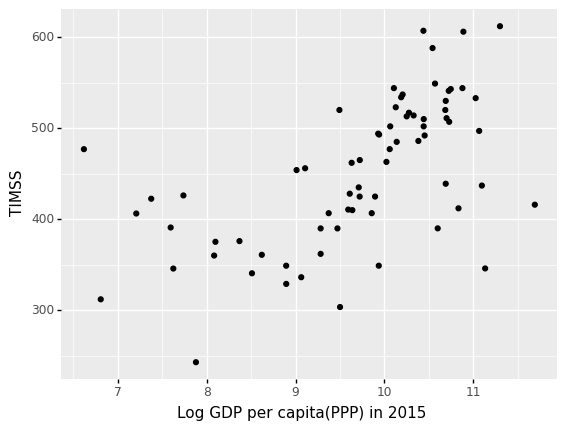

<ggplot: (183121665393)>

In [18]:
X = gdp_timss['GDP']
Y = gdp_timss['TIMSS']  

ggplot() + geom_point(aes(x=X, y=Y)) + xlab("Log GDP per capita(PPP) in 2015")

It is obvious that for most countries, the higher their income is, the better their TIMSS score is. But that does not happen for all of them. And that is why we found a relativly small `R-squared`.

---

Now, let's use the same process in order to investigate the relationship between logged income and PIRLS score.

In [19]:
gdp_pirls = gdp_grades_per_country.iloc[:, [0, 1, 2, 4]]

gdp_pirls.head()

,Country Name,Country Code,GDP,PIRLS
0,Qatar,QAT,11.693157,429.0
1,Singapore,SGP,11.300871,573.0
2,Kuwait,KWT,11.134243,394.0
3,United Arab Emirates,ARE,11.097037,440.0
4,Norway,NOR,11.066768,510.0


In [20]:
gdp_pirls.isna().sum()

Country Name     0
Country Code     0
GDP              0
PIRLS           10
dtype: int64

In [21]:
gdp_pirls.dropna(inplace=True)
gdp_pirls.reset_index(drop=True, inplace=True)
gdp_pirls.head()

,Country Name,Country Code,GDP,PIRLS
0,Qatar,QAT,11.693157,429.0
1,Singapore,SGP,11.300871,573.0
2,Kuwait,KWT,11.134243,394.0
3,United Arab Emirates,ARE,11.097037,440.0
4,Norway,NOR,11.066768,510.0


In [22]:
mod = smf.ols("PIRLS ~ GDP", data=gdp_pirls)
gdp_pirls_res = mod.fit()
gdp_pirls_res.params

Intercept    42.619127
GDP          43.912415
dtype: float64

* So, the relationship between `PIRLS` ($y$) and `logged income` ($x$) is:

$$ y = 42.619127 + 43.912415 x $$

* Below, is the summary table of the model.

In [23]:
gdp_pirls_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PIRLS   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     55.61
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           2.48e-10
Time:                        16:08:00   Log-Likelihood:                -367.97
No. Observations:                  68   AIC:                             739.9
Df Residuals:                      66   BIC:                             744.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.6191     57.790      0.737      0.463     -72.762     158.000
GDP           43.9124      5.889      7.457      0.000      32.155      55.669
==============================================================================
Omnibus:                       10.020   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.389
Skew:                          -0.951   Prob(JB):                      0.00555
Kurtosis:                       3.226   Cond. No.                         85.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We found an `R-squared` of 0.457 which is better than before, but still it doesn't show an absolute relationship.  However, the `p-value` of the Intercept is 0.463 (>0.05) so the Intercept occured probably by chance. Let's create a plot in order to visualize the relationship.

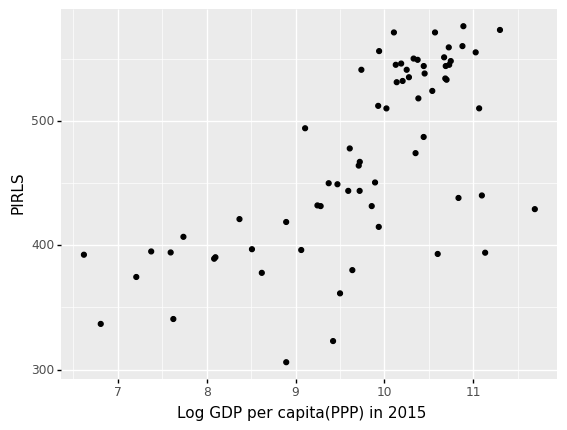

<ggplot: (-9223371853724524351)>

In [24]:
X = gdp_pirls['GDP']
Y = gdp_pirls['PIRLS']

ggplot() + geom_point(aes(x=X, y=Y)) + xlab("Log GDP per capita(PPP) in 2015")

Now, it is more obvious that the countries with higher income have a higher PIRLS score. But still we can find some countries with relativly high income but relativly low score.
<br />
<br />
<br />

## Q2: Years of Schooling and Test Scores

We will explore how much years of schooling impact test scores, taking account of the per capita income.

* Let's find the residuals for `TIMSS ~ income` to see how much of what cannot be explained by income can be explained by years of schooling.

In [25]:
gdp_timss_res.fittedvalues

0     534.259264
1     517.882914
2     510.926880
3     509.373659
4     508.110049
         ...    
66    363.155398
67    354.013030
68    346.996738
69    330.301531
70    322.390147
Length: 71, dtype: float64

In [26]:
gdp_timss['pred'] = gdp_timss_res.fittedvalues
gdp_timss.head()

,Country Name,Country Code,GDP,TIMSS,pred
0,Qatar,QAT,11.693157,416.0,534.259264
1,Singapore,SGP,11.300871,612.0,517.882914
2,Kuwait,KWT,11.134243,346.0,510.926880
3,United Arab Emirates,ARE,11.097037,437.0,509.373659
4,Norway,NOR,11.066768,497.0,508.110049


In [27]:
gdp_timss['residuals'] = gdp_timss['TIMSS'] - gdp_timss['pred']
gdp_timss.head()

,Country Name,Country Code,GDP,TIMSS,pred,residuals
0,Qatar,QAT,11.693157,416.0,534.259264,-118.259264
1,Singapore,SGP,11.300871,612.0,517.882914,94.117086
2,Kuwait,KWT,11.134243,346.0,510.926880,-164.926880
3,United Arab Emirates,ARE,11.097037,437.0,509.373659,-72.373659
4,Norway,NOR,11.066768,497.0,508.110049,-11.110049


* Now, we will find the residuals for `PIRLS ~ income`.

In [28]:
gdp_pirls['pred'] = gdp_pirls_res.fittedvalues
gdp_pirls['residuals'] = gdp_pirls['PIRLS'] - gdp_pirls['pred']
gdp_pirls.head()

,Country Name,Country Code,GDP,PIRLS,pred,residuals
0,Qatar,QAT,11.693157,429.0,556.093876,-127.093876
1,Singapore,SGP,11.300871,573.0,538.867663,34.132337
2,Kuwait,KWT,11.134243,394.0,531.550639,-137.550639
3,United Arab Emirates,ARE,11.097037,440.0,529.916813,-89.916813
4,Norway,NOR,11.066768,510.0,528.587627,-18.587627


Let's read the file which contains `average years of schooling` data from Barro, Robert J. and Jong-Wha Lee, A New Data Set of Educational Attainment in the World, 1950-2010, Journal of Development Economics, 2013, 104, 194-198. You will use the values reported for 2010.

In [29]:
avg_school_years = pd.read_stata(avg_school_years_file)

print(avg_school_years.shape)
avg_school_years.head()

(1898, 20)


,BLcode,country,year,sex,agefrom,ageto,lu,lp,lpc,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,WBcode,region_code
0,1.0,Algeria,1950.0,MF,15.0,999.0,80.684593,17.563400,3.745905,1.454129,0.459588,0.297876,0.164790,0.846457,0.744399,0.092804,0.009253,5241.0,DZA,Middle East and North Africa
1,1.0,Algeria,1955.0,MF,15.0,999.0,81.050957,17.018442,3.464397,1.639253,0.495228,0.259414,0.141776,0.835015,0.728405,0.098586,0.008024,5699.0,DZA,Middle East and North Africa
2,1.0,Algeria,1960.0,MF,15.0,999.0,82.611153,14.313748,3.069391,2.752519,1.049408,0.322578,0.173414,0.880083,0.706000,0.164163,0.009920,6073.0,DZA,Middle East and North Africa
3,1.0,Algeria,1965.0,MF,15.0,999.0,80.931877,14.420929,4.006678,4.209821,1.791863,0.426420,0.226569,1.096061,0.831003,0.251998,0.013060,6374.0,DZA,Middle East and North Africa
4,1.0,Algeria,1970.0,MF,15.0,999.0,73.636833,19.217760,5.225636,6.686831,3.256895,0.344648,0.179372,1.554976,1.155191,0.389305,0.010480,7100.0,DZA,Middle East and North Africa


Keep 2010 data and rename columns.

In [30]:
school_years = avg_school_years[['country', 'WBcode', 'yr_sch', 'region_code']][avg_school_years['year'] == 2010.0]

school_years.rename(columns={'country':'Country Name', 'WBcode':'Country Code'}, inplace=True)

print(school_years.shape)
school_years.head()

(146, 4)


,Country Name,Country Code,yr_sch,region_code
12,Algeria,DZA,6.678049,Middle East and North Africa
25,Benin,BEN,4.430164,Sub-Saharan Africa
38,Botswana,BWA,9.554915,Sub-Saharan Africa
51,Burundi,BDI,3.346481,Sub-Saharan Africa
64,Cameroon,CMR,6.154877,Sub-Saharan Africa


Let's merge the school years with the GDP for each country.

In [31]:
school_years_gdp = pd.merge(school_years,
                            gdp_grades_per_country[['Country Code', 'GDP']],
                            on='Country Code')

print(school_years_gdp.shape)
school_years_gdp.head()

(72, 5)


,Country Name,Country Code,yr_sch,region_code,GDP
0,Benin,BEN,4.430164,Sub-Saharan Africa,7.594465
1,Botswana,BWA,9.554915,Sub-Saharan Africa,9.639291
2,Burundi,BDI,3.346481,Sub-Saharan Africa,6.617958
3,Cameroon,CMR,6.154877,Sub-Saharan Africa,8.098358
4,Congo,COG,5.941449,Sub-Saharan Africa,8.620272


Now, we will do a regression between `schooling years` and `income`.

In [32]:
mod = smf.ols("yr_sch ~ GDP", data=school_years_gdp)
school_years_gdp_res = mod.fit()
school_years_gdp_res.params

Intercept   -10.130974
GDP           1.959388
dtype: float64

Here, is the summary table with an `R-squared` of 0.612 which is satisfying. We also se that both p-values are 0 which means that the Intercept and the slope did not occure by chance.

In [33]:
school_years_gdp_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yr_sch   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     110.6
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           4.74e-16
Time:                        16:08:04   Log-Likelihood:                -138.89
No. Observations:                  72   AIC:                             281.8
Df Residuals:                      70   BIC:                             286.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1310      1.838     -5.512      0.000     -13.797      -6.465
GDP            1.9594      0.186     10.515      0.000       1.588       2.331
==============================================================================
Omnibus:                        8.402   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.855
Skew:                          -0.724   Prob(JB):                       0.0197
Kurtosis:                       3.723   Cond. No.                         92.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's calculate the residuals.

In [34]:
school_years_gdp['pred'] = school_years_gdp_res.fittedvalues
school_years_gdp['residuals'] = school_years_gdp['yr_sch'] - school_years_gdp['pred']

school_years_gdp.head()

,Country Name,Country Code,yr_sch,region_code,GDP,pred,residuals
0,Benin,BEN,4.430164,Sub-Saharan Africa,7.594465,4.749533,-0.319368
1,Botswana,BWA,9.554915,Sub-Saharan Africa,9.639291,8.756141,0.798774
2,Burundi,BDI,3.346481,Sub-Saharan Africa,6.617958,2.836176,0.510305
3,Cameroon,CMR,6.154877,Sub-Saharan Africa,8.098358,5.736855,0.418022
4,Congo,COG,5.941449,Sub-Saharan Africa,8.620272,6.759486,-0.818037


We will merge the dataframes in order to get, for each country, the `schooling years residuals` and `TIMSS residuals`.

In [35]:
timss_sch_years_residualized = pd.merge(school_years_gdp[['Country Name', 'Country Code', 'region_code', 'residuals']],
                                        gdp_timss[['Country Code', 'residuals']],
                                        on='Country Code')

timss_sch_years_residualized.rename(columns={'residuals_x':'residuals_yr_sch',
                             'residuals_y':'residuals_TIMSS'},
                             inplace=True)

print(timss_sch_years_residualized.shape)
timss_sch_years_residualized.head()

(65, 5)


,Country Name,Country Code,region_code,residuals_yr_sch,residuals_TIMSS
0,Benin,BEN,Sub-Saharan Africa,-0.319368,27.793790
1,Botswana,BWA,Sub-Saharan Africa,0.798774,-38.518652
2,Burundi,BDI,Sub-Saharan Africa,0.510305,154.588308
3,Cameroon,CMR,Sub-Saharan Africa,0.418022,-8.950429
4,Congo,COG,Sub-Saharan Africa,-0.818037,-45.014914


Now, we will do a regression between `schooling years residuals` and `TIMSS residuals` and we will find what can be explained by schooling years and not by income about TIMSS scores.

In [36]:
mod = smf.ols("residuals_TIMSS ~ residuals_yr_sch", data=timss_sch_years_residualized)
timss_sch_years_residualized_res = mod.fit()
timss_sch_years_residualized_res.params

Intercept            1.415540
residuals_yr_sch    21.585637
dtype: float64

In [37]:
timss_sch_years_residualized_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        residuals_TIMSS   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     29.30
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           1.03e-06
Time:                        16:08:05   Log-Likelihood:                -350.69
No. Observations:                  65   AIC:                             705.4
Df Residuals:                      63   BIC:                             709.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4155      6.734      0.210      0.834     -12.041      14.872
residuals_yr_sch    21.5856      3.988      5.413      0.000      13.617      29.554
==============================================================================
Omnibus:                        2.751   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.253   Jarque-Bera (JB):                1.934
Skew:                           0.370   Prob(JB):                        0.380
Kurtosis:                       3.407   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

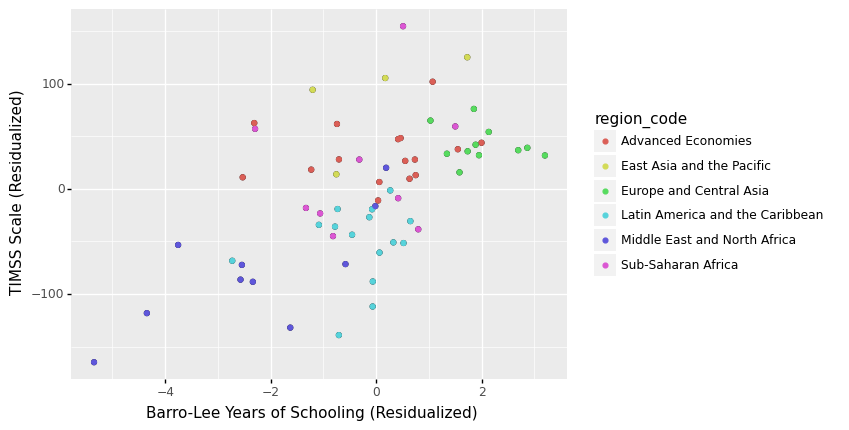

<ggplot: (183130189302)>

In [38]:
X = timss_sch_years_residualized['residuals_yr_sch']
Y = timss_sch_years_residualized['residuals_TIMSS']
area = timss_sch_years_residualized['region_code']

ggplot(timss_sch_years_residualized, aes(X, Y)) + geom_point() + geom_point(aes(colour = area)) +\
    xlab("Barro-Lee Years of Schooling (Residualized)") + ylab("TIMSS Scale (Residualized)")

As you can see there is a relationship between years of schooling and TIMSS score with is validated from an `R-square` of 0.317 and from the above plot. However, tha p-value of the Intercept is 0.834 which is extremely high and tells us that it occured probably by chance.
<br />
<br />

Let's follow the same process in order to investigate the relationship between years of schooling and PIRLS score.

In [39]:
pirls_sch_years_residualized = pd.merge(school_years_gdp[['Country Name', 'Country Code','region_code',
                                                          'residuals']],
                                        gdp_pirls[['Country Code', 'residuals']],
                                        on='Country Code')

pirls_sch_years_residualized.rename(columns={'residuals_x':'residuals_yr_sch',
                             'residuals_y':'residuals_PIRLS'},
                             inplace=True)

pirls_sch_years_residualized.head()

,Country Name,Country Code,region_code,residuals_yr_sch,residuals_PIRLS
0,Benin,BEN,Sub-Saharan Africa,-0.319368,18.086246
1,Botswana,BWA,Sub-Saharan Africa,0.798774,-85.903688
2,Burundi,BDI,Sub-Saharan Africa,0.510305,59.144563
3,Cameroon,CMR,Sub-Saharan Africa,0.418022,-7.893609
4,Congo,COG,Sub-Saharan Africa,-0.818037,-43.344434


In [40]:
mod = smf.ols("residuals_PIRLS ~ residuals_yr_sch", data=pirls_sch_years_residualized)
pirls_sch_years_residualized_res = mod.fit()
pirls_sch_years_residualized_res.params

Intercept            0.694772
residuals_yr_sch    20.253116
dtype: float64

In [41]:
pirls_sch_years_residualized_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        residuals_PIRLS   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     33.96
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           2.27e-07
Time:                        16:08:08   Log-Likelihood:                -326.38
No. Observations:                  63   AIC:                             656.8
Df Residuals:                      61   BIC:                             661.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6948      5.509      0.126      0.900     -10.320      11.710
residuals_yr_sch    20.2531      3.475      5.828      0.000      13.304      27.202
==============================================================================
Omnibus:                       14.661   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.484
Skew:                          -0.843   Prob(JB):                     2.16e-05
Kurtosis:                       5.311   Cond. No.                         1.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

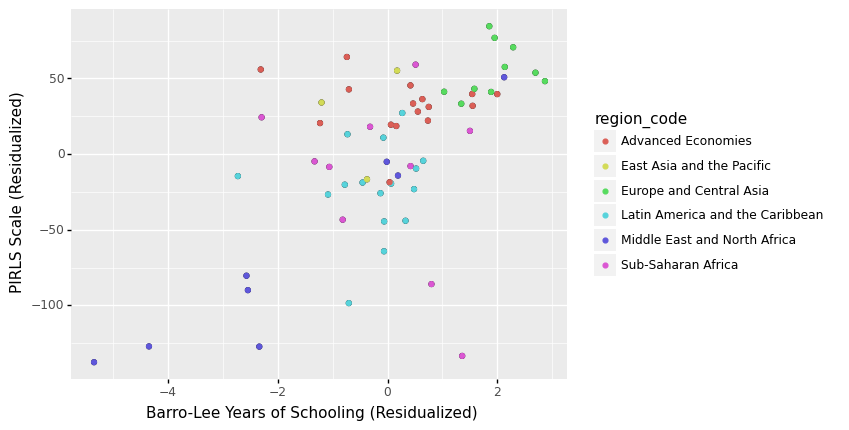

<ggplot: (183130305642)>

In [42]:
X = pirls_sch_years_residualized['residuals_yr_sch']
Y = pirls_sch_years_residualized['residuals_PIRLS']
area = pirls_sch_years_residualized['region_code']

ggplot(pirls_sch_years_residualized, aes(X, Y)) + geom_point() + geom_point(aes(colour = area)) +\
    xlab("Barro-Lee Years of Schooling (Residualized)") + ylab("PIRLS Scale (Residualized)")

We can see that there is a relationship between years of schooling and TIMSS score with is validated from an `R-square` of 0.358 and from the above plot. But, ideally we would like to have a higher `R-square`.

**Note:** Both `p-values` of Intercept are >0.8 (0.834 and 0.9) which tells as that the Intercept occurred just by random chance. However, the slope p-value is always ~ 0 which mean that is hace not occured by chance.

<br />
<br />

## Q3: Compare New and Previous Estimates

To see if the results of the authors of [A Rosetta Stone for Human Capital] make sense, we can compare their scales with other estimates of learning outcomes. So, let's read the file which contains learning outcome estimates from the World Bank, as reported in Altinok, Nadir, Noam Angrist, and Harry Anthony Patrinos, Global Data Set on Education Quality (1965-2015), World Bank Policy Research Working Paper, 2018. 

In [43]:
wb_estimates  = pd.read_stata(wb_estimates_file)

wb_estimates.rename(columns={'cntabb':'Country Code',
                             'country':'Country Name'}, inplace=True)

print(wb_estimates.shape)
wb_estimates.head()

(1849, 6)


,Country Name,idcntry,Country Code,year,HLO,low_threshold
0,"Abu Dhabi, UAE",7842,ADA,1965,NaN,NaN
1,"Abu Dhabi, UAE",7842,ADA,1970,NaN,NaN
2,"Abu Dhabi, UAE",7842,ADA,1975,NaN,NaN
3,"Abu Dhabi, UAE",7842,ADA,1980,NaN,NaN
4,"Abu Dhabi, UAE",7842,ADA,1985,NaN,NaN


In [44]:
wb_estimates.isna().sum()

Country Name        0
idcntry             0
Country Code        0
year                0
HLO              1223
low_threshold    1223
dtype: int64

We see that there are some `NaN` values that we do not need. Let's drop them.

In [45]:
wb_estimates.dropna(inplace=True)
wb_estimates.reset_index(drop=True, inplace=True)
wb_estimates.head()

,Country Name,idcntry,Country Code,year,HLO,low_threshold
0,"Abu Dhabi, UAE",7842,ADA,2010,428.679993,73.830002
1,"Abu Dhabi, UAE",7842,ADA,2015,437.070007,73.750000
2,Albania,8,ALB,2000,400.649994,57.750000
3,Albania,8,ALB,2005,399.320007,60.150002
4,Albania,8,ALB,2010,402.750000,61.320000


Now, we will add the `country codes` to every country in the dataframe that we just created.

In [46]:
wb_estimates = pd.merge(wb_estimates,
                        gdp_grades_per_country['Country Code'],
                        on='Country Code')

print(wb_estimates.shape)
wb_estimates.head()

(384, 6)


,Country Name,idcntry,Country Code,year,HLO,low_threshold
0,Argentina,32,ARG,1995,377.660004,67.989998
1,Argentina,32,ARG,2000,409.869995,60.360001
2,Argentina,32,ARG,2005,405.440002,64.889999
3,Argentina,32,ARG,2010,413.269989,65.949997
4,Argentina,32,ARG,2015,429.380005,70.860001


We need the latest year for which estimates are available for each country. We will get it with a series of commands retrieved from a stack overflow [post](https://stackoverflow.com/questions/31842306/delete-the-entire-row-if-the-a-value-in-value-is-equal-to-previous-row-in-python/31842567#31842567).

In [47]:
wb_estimates = wb_estimates.groupby((wb_estimates["Country Name"] != wb_estimates["Country Name"].shift(-1)).cumsum().values).first()

wb_estimates = wb_estimates.iloc[1:]

print(wb_estimates.shape)
wb_estimates.head()

(77, 6)


,Country Name,idcntry,Country Code,year,HLO,low_threshold
1,Argentina,32,ARG,2015,429.380005,70.860001
2,Armenia,51,ARM,2010,469.070007,86.129997
3,Australia,36,AUS,2015,509.220001,91.529999
4,Austria,40,AUT,2015,519.539978,88.510002
5,Azerbaijan,31,AZE,2010,453.140015,77.459999


Now, we will merge the estimates from the World Bank with the `country_scores` that contains TIMSS and PRILS scores. Also, we rename some columns.

In [48]:
all_estimates = pd.merge(wb_estimates[['Country Name', 'Country Code', 'low_threshold']],
                        country_scores[['Country Code', 'Percent Above Math Benchmark (400 on TIMSS Scale)',
                                       'Percent Above Reading Benchmark (400 on PIRLS Scale)']],
                        on='Country Code')

all_estimates.rename(columns={'Percent Above Math Benchmark (400 on TIMSS Scale)':'TIMSS_400_%',
                             'Percent Above Reading Benchmark (400 on PIRLS Scale)':'PIRLS_400_%'},
                             inplace=True)

print(all_estimates.shape)
all_estimates.head()

(77, 5)


,Country Name,Country Code,low_threshold,TIMSS_400_%,PIRLS_400_%
0,Argentina,ARG,70.860001,51.000000,66.000000
1,Armenia,ARM,86.129997,71.505402,NaN
2,Australia,AUS,91.529999,90.000000,92.932800
3,Austria,AUT,88.510002,95.302193,97.104111
4,Azerbaijan,AZE,77.459999,72.284508,81.859566


Let's focus only on `TIMSS - Wrold Bank estimates`.

In [49]:
timss_estimates = all_estimates.iloc[:, :4]

print(timss_estimates.shape)
timss_estimates.head()

(77, 4)


,Country Name,Country Code,low_threshold,TIMSS_400_%
0,Argentina,ARG,70.860001,51.000000
1,Armenia,ARM,86.129997,71.505402
2,Australia,AUS,91.529999,90.000000
3,Austria,AUT,88.510002,95.302193
4,Azerbaijan,AZE,77.459999,72.284508


In [50]:
timss_estimates.isna().sum()

Country Name     0
Country Code     0
low_threshold    0
TIMSS_400_%      8
dtype: int64

Dropping NaNs.

In [51]:
timss_estimates.dropna(inplace=True)
timss_estimates.reset_index(drop=True, inplace=True)
print(timss_estimates.shape)
timss_estimates.head()

(69, 4)


,Country Name,Country Code,low_threshold,TIMSS_400_%
0,Argentina,ARG,70.860001,51.000000
1,Armenia,ARM,86.129997,71.505402
2,Australia,AUS,91.529999,90.000000
3,Austria,AUT,88.510002,95.302193
4,Azerbaijan,AZE,77.459999,72.284508


To compare the new and previous results we will run a Spearman test.

In [52]:
X = timss_estimates['low_threshold']
Y = timss_estimates['TIMSS_400_%']

print('Spearman', stats.spearmanr(X, Y))

Spearman SpearmanrResult(correlation=0.8973790562032015, pvalue=1.6879737641244243e-25)


As we can see, the correlation in near 0.9 which means that there is an important relationship between the two results. Also, the fact that p-value is very small tells us that the correlation value didn't occured by chance.

Let's create a plot in order to see a visual representation of the relationship.

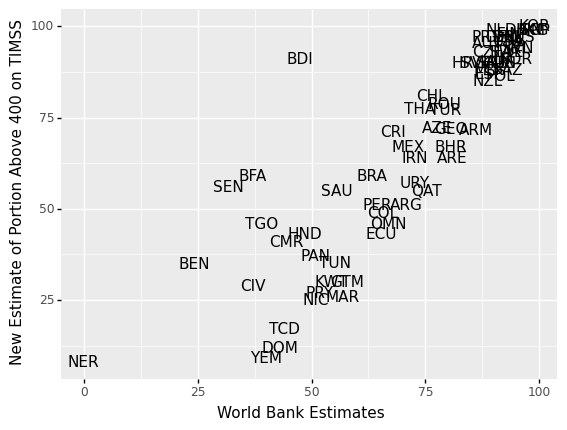

<ggplot: (-9223371853723363654)>

In [53]:
data = timss_estimates['Country Code']

ggplot(timss_estimates, aes(X, Y)) + geom_text(label=data) + xlab("World Bank Estimates") +\
    ylab('New Estimate of Portion Above 400 on TIMSS')

Let's focus only relationship of `PIRLS - Wrold Bank estimates`.

In [54]:
pirls_estimates = all_estimates.iloc[:, [0,1,2,4]]

print(pirls_estimates.shape)
pirls_estimates.head()

(77, 4)


,Country Name,Country Code,low_threshold,PIRLS_400_%
0,Argentina,ARG,70.860001,66.000000
1,Armenia,ARM,86.129997,NaN
2,Australia,AUS,91.529999,92.932800
3,Austria,AUT,88.510002,97.104111
4,Azerbaijan,AZE,77.459999,81.859566


In [55]:
pirls_estimates.isna().sum()

Country Name      0
Country Code      0
low_threshold     0
PIRLS_400_%      12
dtype: int64

In [56]:
pirls_estimates.dropna(inplace=True)
pirls_estimates.reset_index(drop=True, inplace=True)
print(pirls_estimates.shape)
pirls_estimates.head()

(65, 4)


,Country Name,Country Code,low_threshold,PIRLS_400_%
0,Argentina,ARG,70.860001,66.000000
1,Australia,AUS,91.529999,92.932800
2,Austria,AUT,88.510002,97.104111
3,Azerbaijan,AZE,77.459999,81.859566
4,Benin,BEN,24.350000,35.000000


In [57]:
X = pirls_estimates['low_threshold']
Y = pirls_estimates['PIRLS_400_%']

print('Spearman', stats.spearmanr(X, Y))

Spearman SpearmanrResult(correlation=0.9045173418249431, pvalue=5.2905847721937165e-25)


As we can also see here, the correlation in near 0.9 which means that there is an important relationship between the two results. Also, the fact that p-value is very small tells us that the correlation value did't occured by chance.

Let's create a plot in order to see a visual representation of the relationship.

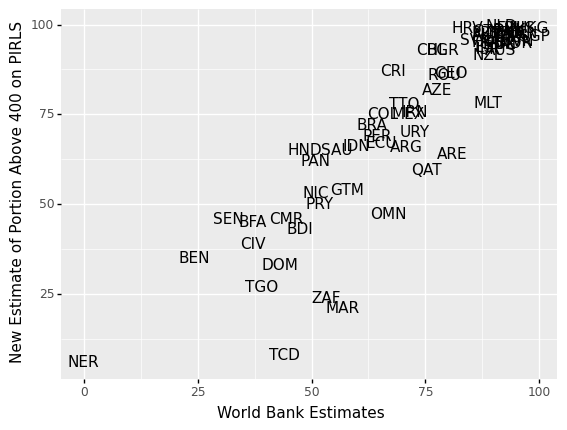

<ggplot: (-9223371853723363738)>

In [58]:
data = pirls_estimates['Country Code']

ggplot(pirls_estimates, aes(X, Y)) + geom_text(label=data) + xlab("World Bank Estimates") +\
    ylab('New Estimate of Portion Above 400 on PIRLS')

## Q4: Skills Intensity

Let's study the relationship between the skills of the people in each country and the value of its exports.

To begin with, let's read the file that contains the education data.

In [59]:
usa = pd.read_csv(usa_file)

print(usa.shape)
usa.head()

(371618, 15)


,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
0,2000,200004,1,600.0,2000000000014,17,1,1,618.0,8,81,1,10,3130,797
1,2000,200004,1,600.0,2000000000014,17,1,2,684.0,8,81,1,10,7210,467
2,2000,200004,2,600.0,2000000000024,48,1,1,618.0,6,62,1,10,8030,359
3,2000,200004,2,600.0,2000000000024,48,1,2,609.0,6,62,3,30,5240,617
4,2000,200004,2,600.0,2000000000024,48,1,3,621.0,6,62,1,10,9360,877


In [60]:
usa = usa.astype({'PERWT':'int64'})
print(usa.dtypes)

YEAR          int64
SAMPLE        int64
SERIAL        int64
HHWT        float64
CLUSTER       int64
STRATA        int64
GQ            int64
PERNUM        int64
PERWT         int64
EDUC          int64
EDUCD         int64
EMPSTAT       int64
EMPSTATD      int64
OCC2010       int64
IND           int64
dtype: object


Here, we group by `IND` which is the industry id and we sum the `PERWT` column which shows how many persons in the US population are represented by a given person in the data. So, we get the total population for each industry. After thatr, we rename `PERWT` columns to `SUM_PPL`.

In [61]:
all_per_ind = pd.DataFrame(usa.groupby('IND')['PERWT'].sum())
all_per_ind = all_per_ind.reset_index()
all_per_ind.rename(columns={'PERWT':'SUM_PPL'}, inplace=True)

print(all_per_ind.shape)
all_per_ind.head()

(266, 2)


,IND,SUM_PPL
0,0,108371644
1,17,1391515
2,18,723084
3,19,32080
4,27,147320


Let's filter the data and get the school graduates (`EDUC` >= 6).

In [62]:
usa_sch = usa[usa['EDUC'] >= 6]

print(usa_sch.shape)
usa_sch.head()

(242038, 15)


,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
0,2000,200004,1,600.0,2000000000014,17,1,1,618,8,81,1,10,3130,797
1,2000,200004,1,600.0,2000000000014,17,1,2,684,8,81,1,10,7210,467
2,2000,200004,2,600.0,2000000000024,48,1,1,618,6,62,1,10,8030,359
3,2000,200004,2,600.0,2000000000024,48,1,2,609,6,62,3,30,5240,617
4,2000,200004,2,600.0,2000000000024,48,1,3,621,6,62,1,10,9360,877


Here, we group by `IND` and we sum the `PERWT` column as we did before. So, we get the total population of school graduates for each industry. After thatr, we rename `PERWT` columns to `SUM_SCH`.

In [63]:
sch_grads_per_ind = pd.DataFrame(usa_sch.groupby('IND')['PERWT'].sum())
sch_grads_per_ind.rename(columns={'PERWT':'SUM_SCH'}, inplace=True)
sch_grads_per_ind = sch_grads_per_ind.reset_index()
sch_grads_per_ind.head()

,IND,SUM_SCH
0,0,28314555
1,17,806904
2,18,516534
3,19,29645
4,27,112982


Now, let's filter the data and get the college graduates (`EDUC` >= 10) and we group by `IND` and we sum the `PERWT` column as we did before. So, we get the total population of college graduates for each industry. After thatr, we rename `PERWT` columns to `SUM_COL`.

In [64]:
usa_col = usa[usa['EDUC'] >= 10]

col_grads_per_ind = pd.DataFrame(usa_col.groupby('IND')['PERWT'].sum())
col_grads_per_ind.rename(columns={'PERWT':'SUM_COL'}, inplace=True)
col_grads_per_ind = col_grads_per_ind.reset_index()
col_grads_per_ind.head()

,IND,SUM_COL
0,0,5117532
1,17,133389
2,18,70935
3,19,10095
4,27,7917


Let's merge the three dataframes that we just created.

In [65]:
skills_intensity_industry = pd.merge(all_per_ind,
                                     sch_grads_per_ind,
                                     on='IND')

skills_intensity_industry = pd.merge(skills_intensity_industry,
                                     col_grads_per_ind,
                                     on='IND')

skills_intensity_industry.rename(columns={'IND':'ind2000'}, inplace=True)

print(skills_intensity_industry.shape)
skills_intensity_industry.head()

(265, 4)


,ind2000,SUM_PPL,SUM_SCH,SUM_COL
0,0,108371644,28314555,5117532
1,17,1391515,806904,133389
2,18,723084,516534,70935
3,19,32080,29645,10095
4,27,147320,112982,7917


Now, we calculate the percentage of school and college graduates for each industry.

In [66]:
skills_intensity_industry['SCH_POR'] = skills_intensity_industry['SUM_SCH'] / skills_intensity_industry['SUM_PPL']
skills_intensity_industry['COL_POR'] = skills_intensity_industry['SUM_COL'] / skills_intensity_industry['SUM_PPL']

skills_intensity_industry = skills_intensity_industry[['ind2000', 'SCH_POR', 'COL_POR']]

skills_intensity_industry.head()

,ind2000,SCH_POR,COL_POR
0,0,0.261273,0.047222
1,17,0.579874,0.095859
2,18,0.714349,0.098101
3,19,0.924096,0.314682
4,27,0.766916,0.053740


The data that we have so far is from 2000. But the industry codes for 1990 and 2000 are not the same and we need to use data from 1990. So, let's read the file that maps industry codes of 1990 and 2000.

In [67]:
cw_ind = pd.read_stata(cw_ind_file)

print(cw_ind.shape)
cw_ind.head()

(712, 3)


,ind2000,ind1990ddx,weight
0,17,10,0.994016
1,17,31,0.002637
2,17,121,0.001740
3,17,561,0.001607
4,18,11,0.990907


Let's join the two dataframes.

In [68]:
cw_ind = cw_ind.join(skills_intensity_industry.set_index('ind2000'), on='ind2000')

print(cw_ind.shape)
cw_ind.head()

(712, 5)


,ind2000,ind1990ddx,weight,SCH_POR,COL_POR
0,17,10,0.994016,0.579874,0.095859
1,17,31,0.002637,0.579874,0.095859
2,17,121,0.001740,0.579874,0.095859
3,17,561,0.001607,0.579874,0.095859
4,18,11,0.990907,0.714349,0.098101


Now, we reweight the skill percentages in order to be compatable for 1990 industry codes.

In [69]:
cw_ind['SCH_POR'] = cw_ind['SCH_POR'] * cw_ind['weight']
cw_ind['COL_POR'] = cw_ind['COL_POR'] * cw_ind['weight']

cw_ind.head()

,ind2000,ind1990ddx,weight,SCH_POR,COL_POR
0,17,10,0.994016,0.576404,0.095285
1,17,31,0.002637,0.001529,0.000253
2,17,121,0.001740,0.001009,0.000167
3,17,561,0.001607,0.000932,0.000154
4,18,11,0.990907,0.707853,0.097209


Keeping the necessary columns.

In [70]:
skills_intensity_industry = cw_ind[['ind1990ddx', 'SCH_POR', 'COL_POR']]

print(skills_intensity_industry.shape)
skills_intensity_industry.head()

(712, 3)


,ind1990ddx,SCH_POR,COL_POR
0,10,0.576404,0.095285
1,31,0.001529,0.000253
2,121,0.001009,0.000167
3,561,0.000932,0.000154
4,11,0.707853,0.097209


We know that to some `ind1990ddx` correspond more than one `ind2000`. So, we will group them by `ind1990ddx` in order to have the total skill intensity for every industry code.

In [71]:
skills_intensity_industry = pd.DataFrame(skills_intensity_industry.groupby('ind1990ddx').sum())
skills_intensity_industry = skills_intensity_industry.reset_index()

print(skills_intensity_industry.shape)
skills_intensity_industry.head()

(222, 3)


,ind1990ddx,SCH_POR,COL_POR
0,10,0.811546,0.150558
1,11,0.707853,0.097209
2,20,2.010865,0.559366
3,31,1.059608,0.346429
4,32,0.648069,0.174943


Now, we will read the file that contains records showing the exports of different countries in 2018 for different industry sectors.

In [72]:
baci = pd.read_csv(baci_file)

baci.rename(columns={'k':'hs6'}, inplace=True)

print(baci.shape)
baci.head()

(7738903, 6)


,t,i,j,hs6,v,q
0,2018,4,24,845420,101.397000,26.000
1,2018,4,24,848180,2.328000,0.007
2,2018,4,31,570110,1.596000,0.037
3,2018,4,32,340319,8.699331,0.113
4,2018,4,32,610910,1.098000,0.013


We will read the following file in order to map the `HS 6-digit` code with `Standard Industrial Codes (SIC) SIC87` industry codes.

In [73]:
cw_hs6_sic87 = pd.read_stata(cw_hs6_sic87dd_file)

print(cw_hs6_sic87.shape)
cw_hs6_sic87.head()

(6752, 4)


,hs6,sic87dd,share,weights_method
0,10110.0,272.0,1.0,no weights needed
1,10111.0,272.0,1.0,no weights needed
2,10119.0,272.0,1.0,no weights needed
3,10120.0,272.0,1.0,no weights needed
4,10190.0,272.0,1.0,no weights needed


In [74]:
cw_hs6_sic87.isna().sum()

hs6                0
sic87dd           52
share              0
weights_method     0
dtype: int64

Let's drop NaNs.

In [75]:
cw_hs6_sic87.dropna(inplace=True)
cw_hs6_sic87.reset_index(drop=True, inplace=True)
print(cw_hs6_sic87.shape)
cw_hs6_sic87.head()

(6700, 4)


,hs6,sic87dd,share,weights_method
0,10110.0,272.0,1.0,no weights needed
1,10111.0,272.0,1.0,no weights needed
2,10119.0,272.0,1.0,no weights needed
3,10120.0,272.0,1.0,no weights needed
4,10190.0,272.0,1.0,no weights needed


Change codes' type to int.

In [76]:
cw_hs6_sic87 = cw_hs6_sic87.astype({'hs6': 'int32',
                     'sic87dd':'int64'})

cw_hs6_sic87.dtypes

hs6                  int32
sic87dd              int64
share              float32
weights_method    category
dtype: object

Let's join the two dataframes that contain the two different codes (`hs6`, `sic87dd`).

In [77]:
baci = baci.join(cw_hs6_sic87[['hs6', 'sic87dd', 'share']].set_index('hs6'), on='hs6')

print(baci.shape)
baci.head()

(10187981, 8)


,t,i,j,hs6,v,q,sic87dd,share
0,2018,4,24,845420,101.397,26.000,3321.0,0.636426
0,2018,4,24,845420,101.397,26.000,3559.0,0.363574
1,2018,4,24,848180,2.328,0.007,3491.0,0.004934
1,2018,4,24,848180,2.328,0.007,3494.0,0.995066
2,2018,4,31,570110,1.596,0.037,2273.0,1.000000


In [78]:
baci.isna().sum()

t               0
i               0
j               0
hs6             0
v               0
q               0
sic87dd    714469
share      714469
dtype: int64

Again droping the NaNs that occur.

In [79]:
baci.dropna(inplace=True)
baci.reset_index(drop=True, inplace=True)
print(baci.shape)
baci.head()

(9473512, 8)


,t,i,j,hs6,v,q,sic87dd,share
0,2018,4,24,845420,101.397,26.000,3321.0,0.636426
1,2018,4,24,845420,101.397,26.000,3559.0,0.363574
2,2018,4,24,848180,2.328,0.007,3491.0,0.004934
3,2018,4,24,848180,2.328,0.007,3494.0,0.995066
4,2018,4,31,570110,1.596,0.037,2273.0,1.000000


In [80]:
baci = baci.astype({'sic87dd': 'int64'})

In [81]:
baci.dtypes

t            int64
i            int64
j            int64
hs6          int64
v          float64
q          float64
sic87dd      int64
share      float32
dtype: object

Now, we need to adjust the value of the trade flow `v` using the `share` column.

In [82]:
baci['v'] = baci['v'] * baci['share']

baci.head()

,t,i,j,hs6,v,q,sic87dd,share
0,2018,4,24,845420,64.531708,26.000,3321,0.636426
1,2018,4,24,845420,36.865292,26.000,3559,0.363574
2,2018,4,24,848180,0.011486,0.007,3491,0.004934
3,2018,4,24,848180,2.316514,0.007,3494,0.995066
4,2018,4,31,570110,1.596000,0.037,2273,1.000000


After that, we group the trade flow by exporter `i` and SIC87 industry code `sic87dd`, so that we have the total value per exporter and industry.

In [83]:
exports = pd.DataFrame(baci.groupby(['i', 'sic87dd'])['v'].sum())
exports = exports.reset_index()

print(exports.shape)
exports.head()

(67628, 3)


,i,sic87dd,v
0,4,119,68290.428330
1,4,131,39698.892614
2,4,132,43.993665
3,4,134,380.462682
4,4,139,13308.065785


Now, we read the file that will help to map the SIC87 industry codes to the 1990 census industry codes.

In [84]:
cw_sic87_ind1990 = pd.read_stata(cw_sic87_ind1990ddx_file)

cw_sic87_ind1990.rename(columns={'sic87':'sic87dd'}, inplace=True)

print(cw_sic87_ind1990.shape)
cw_sic87_ind1990.head()

(1004, 2)


,ind1990ddx,sic87dd
0,10,111
1,10,112
2,10,115
3,10,116
4,10,119


Let's merge the exports with the new dataframe.

In [85]:
exports = pd.merge(exports,
                   cw_sic87_ind1990,
                   on='sic87dd')

print(exports.shape)
exports.head()

(67052, 4)


,i,sic87dd,v,ind1990ddx
0,4,119,68290.428330,10
1,8,119,480.879539,10
2,12,119,104.191222,10
3,16,119,2.329000,10
4,20,119,0.143736,10


Change industry column to int.

In [86]:
exports = exports.astype({'ind1990ddx':'int64'})

print(exports.dtypes)

i               int64
sic87dd         int64
v             float64
ind1990ddx      int64
dtype: object


Exporter countries are given with the ISO 3-digit country codes, but we need to three letter country code that is used in the rest of our data. To do the mapping we will read the following file.

In [87]:
country_codes = pd.read_csv(country_codes_file, encoding='latin-1')

print(country_codes.shape)
country_codes.head()

(227, 5)


,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND


In [88]:
country_codes.rename(columns={'country_code':'i',
                              'iso_3digit_alpha':'Country Code'}, inplace=True)

country_codes.head(3)

,i,country_name_abbreviation,country_name_full,iso_2digit_alpha,Country Code
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA


Let's merge the dataframes in onrder to add to the exports the three letter country code.

In [89]:
exports = pd.merge(exports,
                   country_codes[['i', 'Country Code']],
                   on='i')

print(exports.shape)
exports.head()

(67052, 5)


,i,sic87dd,v,ind1990ddx,Country Code
0,4,119,68290.428330,10,AFG
1,4,131,39698.892614,10,AFG
2,4,132,43.993665,10,AFG
3,4,134,380.462682,10,AFG
4,4,139,13308.065785,10,AFG


Now, it is the time to create the dataframe that will include all the necessary data for out regressions. First, we will join `exports` and `skills_intensity_industry`.

In [90]:
exports_skills_scores = exports.join(skills_intensity_industry.set_index('ind1990ddx'), on='ind1990ddx')

print(exports_skills_scores.shape)
exports_skills_scores.head()

(67052, 7)


,i,sic87dd,v,ind1990ddx,Country Code,SCH_POR,COL_POR
0,4,119,68290.428330,10,AFG,0.811546,0.150558
1,4,131,39698.892614,10,AFG,0.811546,0.150558
2,4,132,43.993665,10,AFG,0.811546,0.150558
3,4,134,380.462682,10,AFG,0.811546,0.150558
4,4,139,13308.065785,10,AFG,0.811546,0.150558


We rename some columns of the dtaframe `country_scores` in order to keep column names simple.

In [91]:
country_scores.rename(columns={'Median Math Score (TIMSS Scale, 4th Grade)':'TIMSS',
                                'Median Reading Score (PIRLS Scale, 4th Grade)':'PIRLS'}, inplace=True)

country_scores.head()

,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),TIMSS,PIRLS
0,U.A.E.,ARE,64.000000,63.982311,437.000000,440.000000
1,Argentina,ARG,51.000000,66.000000,406.652557,431.443542
2,Armenia,ARM,71.505402,NaN,454.000000,NaN
3,Australia,AUS,90.000000,92.932800,520.000000,534.000000
4,Austria,AUT,95.302193,97.104111,511.000000,533.000000


Now, we connect `country_scores` to the dataframe that we created previously.

In [92]:
exports_skills_scores = exports_skills_scores.\
                            join(country_scores[['Country Code', 'TIMSS', 'PIRLS']]\
                                .set_index('Country Code'),
                            on='Country Code')

exports_skills_scores = exports_skills_scores.astype({'ind1990ddx':'str'})

exports_skills_scores.rename(columns={'Country Code':'country_codes'}, inplace=True)

print(exports_skills_scores.shape)
exports_skills_scores.head()

(67052, 9)


,i,sic87dd,v,ind1990ddx,country_codes,SCH_POR,COL_POR,TIMSS,PIRLS
0,4,119,68290.428330,10,AFG,0.811546,0.150558,NaN,NaN
1,4,131,39698.892614,10,AFG,0.811546,0.150558,NaN,NaN
2,4,132,43.993665,10,AFG,0.811546,0.150558,NaN,NaN
3,4,134,380.462682,10,AFG,0.811546,0.150558,NaN,NaN
4,4,139,13308.065785,10,AFG,0.811546,0.150558,NaN,NaN


In [93]:
exports_skills_scores.dtypes

i                  int64
sic87dd            int64
v                float64
ind1990ddx        object
country_codes     object
SCH_POR          float64
COL_POR          float64
TIMSS            float64
PIRLS            float64
dtype: object

Let's divide `TIMSS` and `PIRLS` score by 1000 and calculate the logged value of the trade flow `v`.

In [94]:
exports_skills_scores['TIMSS_DIV'] = exports_skills_scores['TIMSS'] / 1000
exports_skills_scores['PIRLS_DIV'] = exports_skills_scores['PIRLS'] / 1000
exports_skills_scores['v_logged'] = np.log(exports_skills_scores['v'])

In [95]:
print(exports_skills_scores.shape)
exports_skills_scores.head()

(67052, 12)


,i,sic87dd,v,ind1990ddx,country_codes,SCH_POR,COL_POR,TIMSS,PIRLS,TIMSS_DIV,PIRLS_DIV,v_logged
0,4,119,68290.428330,10,AFG,0.811546,0.150558,NaN,NaN,NaN,NaN,11.131525
1,4,131,39698.892614,10,AFG,0.811546,0.150558,NaN,NaN,NaN,NaN,10.589079
2,4,132,43.993665,10,AFG,0.811546,0.150558,NaN,NaN,NaN,NaN,3.784046
3,4,134,380.462682,10,AFG,0.811546,0.150558,NaN,NaN,NaN,NaN,5.941388
4,4,139,13308.065785,10,AFG,0.811546,0.150558,NaN,NaN,NaN,NaN,9.496126


We see that there are many NaN values for TIMSS and PIRLS. We want to drop them because they will alter the results of the regressions. So, we will create two different dataframes, one with no NaN values for TIMSS and one with no NaN values for PIRLS.

In [96]:
exports_skills_scores_timss = exports_skills_scores.copy()

exports_skills_scores_timss.dropna(how='all', 
                             subset=['TIMSS_DIV'],
                             inplace=True)

exports_skills_scores_timss.reset_index(drop=True, inplace=True)
print(exports_skills_scores_timss.shape)
exports_skills_scores_timss.head()

(27490, 12)


,i,sic87dd,v,ind1990ddx,country_codes,SCH_POR,COL_POR,TIMSS,PIRLS,TIMSS_DIV,PIRLS_DIV,v_logged
0,31,119,2312.346783,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,7.746018
1,31,131,80377.093494,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,11.294485
2,31,132,12685.514992,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,9.448216
3,31,134,29591.396652,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,10.295239
4,31,139,5056.142027,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,8.528359


In [97]:
exports_skills_scores_pirls= exports_skills_scores.copy()

exports_skills_scores_pirls.dropna(how='all', 
                             subset=['PIRLS_DIV'],
                             inplace=True)

exports_skills_scores_pirls.reset_index(drop=True, inplace=True)
print(exports_skills_scores_pirls.shape)
exports_skills_scores_pirls.head()

(26401, 12)


,i,sic87dd,v,ind1990ddx,country_codes,SCH_POR,COL_POR,TIMSS,PIRLS,TIMSS_DIV,PIRLS_DIV,v_logged
0,31,119,2312.346783,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,7.746018
1,31,131,80377.093494,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,11.294485
2,31,132,12685.514992,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,9.448216
3,31,134,29591.396652,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,10.295239
4,31,139,5056.142027,10,AZE,0.811546,0.150558,465.0,467.0,0.465,0.467,8.528359


It's time to perform the regressions! In every regression we will take into account the looged value of exports, the country and the industry. The parameters that will change are scores (TIMSS, PIRLS) and skill intensities (COL_POR, SCH_POR). Let's begin with TIMSS and COL_POR.

**Note:** we put countries and industries inside the C() method because they are categorical variables.

In [98]:
mod = smf.ols("v_logged ~ TIMSS_DIV : COL_POR + C(country_codes) + C(ind1990ddx)", data=exports_skills_scores_timss)
exports_skills_scores_res = mod.fit()
print(exports_skills_scores_res.params)
exports_skills_scores_res.summary()

Intercept                   9.942204
C(country_codes)[T.ARG]    -2.281017
C(country_codes)[T.ARM]    -5.487475
C(country_codes)[T.AUS]    -0.799633
C(country_codes)[T.AUT]     0.351633
                             ...    
C(ind1990ddx)[T.40]        -0.926078
C(ind1990ddx)[T.41]        -1.028809
C(ind1990ddx)[T.42]         1.998986
C(ind1990ddx)[T.50]        -0.525636
TIMSS_DIV:COL_POR          10.777137
Length: 152, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               v_logged   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     280.0
Date:                Mon, 28 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:08:45   Log-Likelihood:                -63026.
No. Observations:               27490   AIC:                         1.264e+05
Df Residuals:                   27338   BIC:                         1.276e+05
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   9.9422      0.162     61.259      0.000       9.624      10.260
C(country_codes)[T.ARG]    -2.2810      0.164    -13.925      0.000      -2.602      -1.960
C(country_codes)[T.ARM]    -5.4875      0.169    -32.439      0.000      -5.819      -5.156
C(country_codes)[T.AUS]    -0.7996      0.165     -4.853      0.000      -1.123      -0.477
C(country_codes)[T.AUT]     0.3516      0.164      2.140      0.032       0.030       0.674
C(country_codes)[T.AZE]    -5.8679      0.171    -34.362      0.000      -6.203      -5.533
C(country_codes)[T.BDI]    -9.1320      0.246    -37.132      0.000      -9.614      -8.650
C(country_codes)[T.BEN]    -8.5428      0.206    -41.404      0.000      -8.947      -8.138
C(country_codes)[T.BFA]    -8.4082      0.192    -43.879      0.000      -8.784      -8.033
C(country_codes)[T.BHR]    -3.9029      0.166    -23.447      0.000      -4.229      -3.577
C(country_codes)[T.BRA]    -0.3640      0.163     -2.233      0.026      -0.683      -0.044
C(country_codes)[T.CHL]    -2.3548      0.164    -14.381      0.000      -2.676      -2.034
C(country_codes)[T.CIV]    -4.8268      0.169    -28.496      0.000      -5.159      -4.495
C(country_codes)[T.CMR]    -6.7088      0.177    -37.951      0.000      -7.055      -6.362
C(country_codes)[T.COG]    -7.3862      0.194    -37.987      0.000      -7.767      -7.005
C(country_codes)[T.COL]    -2.3399      0.164    -14.264      0.000      -2.661      -2.018
C(country_codes)[T.CRI]    -3.6861      0.165    -22.381      0.000      -4.009      -3.363
C(country_codes)[T.CZE]     0.2980      0.164      1.814      0.070      -0.024       0.620
C(country_codes)[T.DEU]     2.5618      0.165     15.542      0.000       2.239       2.885
C(country_codes)[T.DNK]    -0.3232      0.166     -1.951      0.051      -0.648       0.002
C(country_codes)[T.DOM]    -4.4557      0.173    -25.794      0.000      -4.794      -4.117
C(country_codes)[T.ECU]    -4.4724      0.167    -26.848      0.000      -4.799      -4.146
C(country_codes)[T.ESP]     1.2425      0.163      7.612      0.000       0.923       1.563
C(country_codes)[T.FIN]    -1.2962      0.166     -7.804      0.000      -1.622      -0.971
C(country_codes)[T.GEO]    -5.6546      0.168    -33.565      0.000      -5.985      -5.324
C(country_codes)[T.GTM]    -4.1181      0.169    -24.436      0.000      -4.448      -3.788
C(country_codes)[T.HKG]    -0.9638      0.170     -5.660      0.000      -1.298      -0.630
C(country_codes)[T.HND]    -4.9076      0.173    -28.346      0.000      -5.247      -4.568
C(country_codes)[T.HRV]    -1.8802      0.164    -11.464      0.000      -2.202      -1.559
C(country_codes)[T.HUN]    -0.4003      0.165     -2.423      0.015      -0.724      -0.077
C(country_codes)[T.IRL]    -1.3004      0.166  

The $R^2$ is 0.607 which is satisfying. The `Intercept` is 9.942204 and the `slope` of `TIMSS_DIV:COL_POR` is 10.777137. Both p-values are 0 which means that they are reliable.

In [99]:
mod = smf.ols("v_logged ~ PIRLS_DIV : COL_POR + C(country_codes) + C(ind1990ddx)", data=exports_skills_scores_pirls)
exports_skills_scores_res = mod.fit()
print(exports_skills_scores_res.params)
exports_skills_scores_res.summary()

Intercept                  10.059696
C(country_codes)[T.ARG]    -2.331211
C(country_codes)[T.AUS]    -0.808433
C(country_codes)[T.AUT]     0.325419
C(country_codes)[T.AZE]    -5.856583
                             ...    
C(ind1990ddx)[T.40]        -0.799020
C(ind1990ddx)[T.41]        -0.994584
C(ind1990ddx)[T.42]         2.095869
C(ind1990ddx)[T.50]        -0.582253
PIRLS_DIV:COL_POR           9.923099
Length: 149, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               v_logged   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     284.3
Date:                Mon, 28 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:08:47   Log-Likelihood:                -60244.
No. Observations:               26401   AIC:                         1.208e+05
Df Residuals:                   26252   BIC:                         1.220e+05
Df Model:                         148                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  10.0597      0.166     60.455      0.000       9.734      10.386
C(country_codes)[T.ARG]    -2.3312      0.162    -14.403      0.000      -2.648      -2.014
C(country_codes)[T.AUS]    -0.8084      0.164     -4.929      0.000      -1.130      -0.487
C(country_codes)[T.AUT]     0.3254      0.164      1.986      0.047       0.004       0.647
C(country_codes)[T.AZE]    -5.8566      0.169    -34.660      0.000      -6.188      -5.525
C(country_codes)[T.BDI]    -8.9177      0.244    -36.600      0.000      -9.395      -8.440
C(country_codes)[T.BEN]    -8.5445      0.204    -41.825      0.000      -8.945      -8.144
C(country_codes)[T.BFA]    -8.3453      0.190    -43.893      0.000      -8.718      -7.973
C(country_codes)[T.BGR]    -1.3984      0.164     -8.509      0.000      -1.721      -1.076
C(country_codes)[T.BRA]    -0.4320      0.161     -2.682      0.007      -0.748      -0.116
C(country_codes)[T.CAN]     0.6111      0.165      3.710      0.000       0.288       0.934
C(country_codes)[T.CHL]    -2.4419      0.163    -14.948      0.000      -2.762      -2.122
C(country_codes)[T.CIV]    -4.8933      0.167    -29.316      0.000      -5.220      -4.566
C(country_codes)[T.CMR]    -6.7430      0.175    -38.593      0.000      -7.085      -6.401
C(country_codes)[T.COG]    -7.4306      0.192    -38.662      0.000      -7.807      -7.054
C(country_codes)[T.COL]    -2.4664      0.162    -15.247      0.000      -2.783      -2.149
C(country_codes)[T.CRI]    -3.7826      0.163    -23.153      0.000      -4.103      -3.462
C(country_codes)[T.CZE]     0.2430      0.165      1.475      0.140      -0.080       0.566
C(country_codes)[T.DEU]     2.5553      0.164     15.556      0.000       2.233       2.877
C(country_codes)[T.DNK]    -0.3347      0.166     -2.022      0.043      -0.659      -0.010
C(country_codes)[T.DOM]    -4.5927      0.168    -27.279      0.000      -4.923      -4.263
C(country_codes)[T.ECU]    -4.5604      0.164    -27.761      0.000      -4.882      -4.238
C(country_codes)[T.ESP]     1.1905      0.163      7.312      0.000       0.871       1.510
C(country_codes)[T.FIN]    -1.3166      0.166     -7.909      0.000      -1.643      -0.990
C(country_codes)[T.FRA]     1.5815      0.163      9.696      0.000       1.262       1.901
C(country_codes)[T.GEO]    -5.7243      0.167    -34.180      0.000      -6.053      -5.396
C(country_codes)[T.GTM]    -4.2722      0.165    -25.902      0.000      -4.595      -3.949
C(country_codes)[T.HKG]    -0.8636      0.167     -5.168      0.000      -1.191      -0.536
C(country_codes)[T.HND]    -5.0032      0.171    -29.337      0.000      -5.337      -4.669
C(country_codes)[T.HRV]    -1.9949      0.166    -12.044      0.000      -2.320      -1.670
C(country_codes)[T.HUN]    -0.4225      0.165  

The $R^2$ is 0.616 which is satisfying. The `Intercept` is 10.059696 and the `slope` of `PIRLS_DIV:COL_POR` is 9.923099. Both p-values are 0 which means that they are reliable.

In [100]:
mod = smf.ols("v_logged ~ TIMSS_DIV : SCH_POR + C(country_codes) + C(ind1990ddx)", data=exports_skills_scores_timss)
exports_skills_scores_res = mod.fit()
print(exports_skills_scores_res.params)
exports_skills_scores_res.summary()

Intercept                  9.897191
C(country_codes)[T.ARG]   -2.282324
C(country_codes)[T.ARM]   -5.486192
C(country_codes)[T.AUS]   -0.796000
C(country_codes)[T.AUT]    0.354997
                             ...   
C(ind1990ddx)[T.40]       -1.048489
C(ind1990ddx)[T.41]       -1.523880
C(ind1990ddx)[T.42]        3.277411
C(ind1990ddx)[T.50]       -0.948536
TIMSS_DIV:SCH_POR          2.118531
Length: 152, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               v_logged   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     279.4
Date:                Mon, 28 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:08:49   Log-Likelihood:                -63043.
No. Observations:               27490   AIC:                         1.264e+05
Df Residuals:                   27338   BIC:                         1.276e+05
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   9.8972      0.195     50.710      0.000       9.515      10.280
C(country_codes)[T.ARG]    -2.2823      0.164    -13.902      0.000      -2.604      -1.961
C(country_codes)[T.ARM]    -5.4862      0.169    -32.397      0.000      -5.818      -5.154
C(country_codes)[T.AUS]    -0.7960      0.167     -4.772      0.000      -1.123      -0.469
C(country_codes)[T.AUT]     0.3550      0.166      2.139      0.032       0.030       0.680
C(country_codes)[T.AZE]    -5.8662      0.171    -34.288      0.000      -6.202      -5.531
C(country_codes)[T.BDI]    -9.1275      0.246    -37.046      0.000      -9.610      -8.645
C(country_codes)[T.BEN]    -8.5493      0.207    -41.303      0.000      -8.955      -8.144
C(country_codes)[T.BFA]    -8.4106      0.192    -43.853      0.000      -8.786      -8.035
C(country_codes)[T.BHR]    -3.9029      0.167    -23.432      0.000      -4.229      -3.576
C(country_codes)[T.BRA]    -0.3643      0.163     -2.231      0.026      -0.684      -0.044
C(country_codes)[T.CHL]    -2.3533      0.164    -14.346      0.000      -2.675      -2.032
C(country_codes)[T.CIV]    -4.8327      0.171    -28.251      0.000      -5.168      -4.497
C(country_codes)[T.CMR]    -6.7147      0.178    -37.739      0.000      -7.063      -6.366
C(country_codes)[T.COG]    -7.3980      0.196    -37.726      0.000      -7.782      -7.014
C(country_codes)[T.COL]    -2.3415      0.165    -14.209      0.000      -2.664      -2.018
C(country_codes)[T.CRI]    -3.6858      0.165    -22.362      0.000      -4.009      -3.363
C(country_codes)[T.CZE]     0.3014      0.166      1.815      0.069      -0.024       0.627
C(country_codes)[T.DEU]     2.5658      0.167     15.330      0.000       2.238       2.894
C(country_codes)[T.DNK]    -0.3185      0.169     -1.887      0.059      -0.649       0.012
C(country_codes)[T.DOM]    -4.4676      0.178    -25.167      0.000      -4.816      -4.120
C(country_codes)[T.ECU]    -4.4740      0.167    -26.738      0.000      -4.802      -4.146
C(country_codes)[T.ESP]     1.2447      0.164      7.588      0.000       0.923       1.566
C(country_codes)[T.FIN]    -1.2915      0.170     -7.610      0.000      -1.624      -0.959
C(country_codes)[T.GEO]    -5.6532      0.169    -33.517      0.000      -5.984      -5.323
C(country_codes)[T.GTM]    -4.1230      0.171    -24.145      0.000      -4.458      -3.788
C(country_codes)[T.HKG]    -0.9560      0.178     -5.368      0.000      -1.305      -0.607
C(country_codes)[T.HND]    -4.9079      0.174    -28.167      0.000      -5.249      -4.566
C(country_codes)[T.HRV]    -1.8775      0.165    -11.379      0.000      -2.201      -1.554
C(country_codes)[T.HUN]    -0.3964      0.167     -2.368      0.018      -0.724      -0.068
C(country_codes)[T.IRL]    -1.2961      0.168  

The $R^2$ is 0.607 which is satisfying. The `Intercept` is 9.897191 and the `slope` of `TIMSS_DIV:COL_POR` is 2.118531. Both p-values are 0 which means that they are reliable.

In [101]:
mod = smf.ols("v_logged ~ PIRLS_DIV : SCH_POR + C(country_codes) + C(ind1990ddx)", data=exports_skills_scores_pirls)
exports_skills_scores_res = mod.fit()
print(exports_skills_scores_res.params)
exports_skills_scores_res.summary()

Intercept                  10.144990
C(country_codes)[T.ARG]    -2.334863
C(country_codes)[T.AUS]    -0.767790
C(country_codes)[T.AUT]     0.365762
C(country_codes)[T.AZE]    -5.844731
                             ...    
C(ind1990ddx)[T.40]        -0.897441
C(ind1990ddx)[T.41]        -1.467501
C(ind1990ddx)[T.42]         3.524670
C(ind1990ddx)[T.50]        -0.983988
PIRLS_DIV:SCH_POR           1.578833
Length: 149, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               v_logged   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     283.8
Date:                Mon, 28 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:08:51   Log-Likelihood:                -60260.
No. Observations:               26401   AIC:                         1.208e+05
Df Residuals:                   26252   BIC:                         1.220e+05
Df Model:                         148                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  10.1450      0.205     49.524      0.000       9.743      10.547
C(country_codes)[T.ARG]    -2.3349      0.162    -14.415      0.000      -2.652      -2.017
C(country_codes)[T.AUS]    -0.7678      0.167     -4.592      0.000      -1.095      -0.440
C(country_codes)[T.AUT]     0.3658      0.167      2.191      0.028       0.038       0.693
C(country_codes)[T.AZE]    -5.8447      0.169    -34.520      0.000      -6.177      -5.513
C(country_codes)[T.BDI]    -8.9477      0.244    -36.622      0.000      -9.427      -8.469
C(country_codes)[T.BEN]    -8.5714      0.205    -41.797      0.000      -8.973      -8.169
C(country_codes)[T.BFA]    -8.3690      0.191    -43.860      0.000      -8.743      -7.995
C(country_codes)[T.BGR]    -1.3548      0.168     -8.065      0.000      -1.684      -1.026
C(country_codes)[T.BRA]    -0.4298      0.161     -2.666      0.008      -0.746      -0.114
C(country_codes)[T.CAN]     0.6591      0.169      3.898      0.000       0.328       0.990
C(country_codes)[T.CHL]    -2.4114      0.165    -14.600      0.000      -2.735      -2.088
C(country_codes)[T.CIV]    -4.9172      0.168    -29.294      0.000      -5.246      -4.588
C(country_codes)[T.CMR]    -6.7685      0.176    -38.532      0.000      -7.113      -6.424
C(country_codes)[T.COG]    -7.4684      0.194    -38.575      0.000      -7.848      -7.089
C(country_codes)[T.COL]    -2.4622      0.162    -15.210      0.000      -2.780      -2.145
C(country_codes)[T.CRI]    -3.7658      0.164    -22.968      0.000      -4.087      -3.444
C(country_codes)[T.CZE]     0.2906      0.169      1.719      0.086      -0.041       0.622
C(country_codes)[T.DEU]     2.6002      0.168     15.469      0.000       2.271       2.930
C(country_codes)[T.DNK]    -0.2831      0.171     -1.661      0.097      -0.617       0.051
C(country_codes)[T.DOM]    -4.6311      0.170    -27.162      0.000      -4.965      -4.297
C(country_codes)[T.ECU]    -4.5639      0.164    -27.761      0.000      -4.886      -4.242
C(country_codes)[T.ESP]     1.2242      0.165      7.418      0.000       0.901       1.548
C(country_codes)[T.FIN]    -1.2603      0.172     -7.310      0.000      -1.598      -0.922
C(country_codes)[T.FRA]     1.6178      0.166      9.766      0.000       1.293       1.943
C(country_codes)[T.GEO]    -5.7002      0.169    -33.817      0.000      -6.031      -5.370
C(country_codes)[T.GTM]    -4.2819      0.165    -25.921      0.000      -4.606      -3.958
C(country_codes)[T.HKG]    -0.8045      0.173     -4.639      0.000      -1.144      -0.465
C(country_codes)[T.HND]    -5.0095      0.171    -29.337      0.000      -5.344      -4.675
C(country_codes)[T.HRV]    -1.9451      0.170    -11.419      0.000      -2.279      -1.611
C(country_codes)[T.HUN]    -0.3770      0.169  

The $R^2$ is 0.615 which is satisfying. The `Intercept` is 10.144990 and the `slope` of `PIRLS_DIV:COL_POR` is 1.578833. Both p-values are 0 which means that they are reliable.

All of the $R^2$s that we calculated are >0.6 which tells us that there is an important relationship between the skills of the people in each country and the value of its exports. Also, almost all the p-values are 0 which means that the slopes did not ocure by chance.